In [ ]:
# Imports 

In [46]:
import os 
import pandas as pd 
from os import listdir
from datetime import date, datetime, timedelta
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
import re
%matplotlib inline
from textblob import TextBlob 
import datetime as dt
pd.set_option('display.max_colwidth', 100)
import matplotlib.pyplot as plt 
import plotly.express as px 
import seaborn as sns
from sklearn.model_selection import train_test_split
import pyflux as pf
from scipy.stats import norm
import numpy as np 

In [47]:
# Import Raw File 
# Output Cleaned Dataset to CSV for future use 

In [48]:
raw_data = pd.read_csv('Combined_Raw_Hourly_Data.csv')

## Cleaning Tweets Helper Functions 

In [49]:
# Clean Helper Function

# filter dataframe using 'language' column
def filter_lang(dataframe):
    dataframe = dataframe.loc[dataframe['lang'] == 'en']
    return dataframe

# filter dataframe using 'sourceLabel' column
def filter_source(dataframe):
    dataframe.loc[dataframe['sourceLabel'].str.contains('iPad|iPhone|Mac'), 'sourceLabel'] = 'twitter for ios'
    dataframe.loc[dataframe['sourceLabel'].str.contains('Android'), 'sourceLabel'] = 'twitter for android'
    dataframe.loc[dataframe['sourceLabel'].str.contains('News'), 'sourceLabel'] = 'news sources'
    return dataframe

# apply both filter_lang and filter_source functions to a dataframe
def filtered_data(dataframe):
    dataframe = filter_lang(dataframe)
    dataframe = filter_source(dataframe)
    return dataframe

In [50]:
#https://aronakhmad.medium.com/twitter-data-cleaning-using-python-db1ec2f28f08
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud,STOPWORDS 
from nltk.stem.porter import PorterStemmer

nltk.download(["names","stopwords","state_union","twitter_samples","averaged_perceptron_tagger","vader_lexicon","punkt"])

n_words = set(stopwords.words('english')) # stop words list 
porter = PorterStemmer()


stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))


import numpy as np
import re

def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split()
    temp = [w for w in temp if not w in stopwords]
    temp = " ".join(word for word in temp)
    return temp

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\bhuwa\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhuwa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to
[nltk_data]     C:\Users\bhuwa\AppData\Roaming\nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\bhuwa\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bhuwa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bhuwa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_le

## Cleaning Data by Applying Helper Functions

In [51]:
# Clean using the functions above 
filtered_english_df = filter_lang(raw_data)

filtered_source_df = filter_source(filtered_english_df)

filtered_source_df['content'] = filtered_source_df.content.apply(lambda x: clean(x))

In [103]:
filtered_source_df.to_csv('Filtered_Combined.csv', index=False)

In [89]:
# Clean Data 
# filtered_source_df.to_csv('Filtered_Combined.csv', index=False)

# Output Cleaned Dataset 
data_df = pd.read_csv('Filtered_Combined.csv')

## Using Cleaned Data for Sentiment Analysis and Plotting Crude Oil 

Text(0, 0.5, 'Stock price')

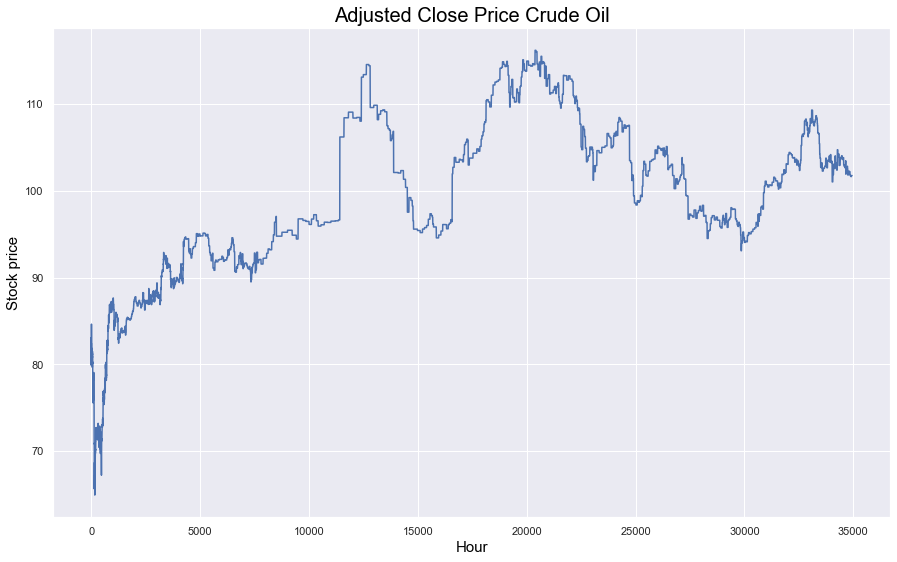

In [104]:
# Sentiment Analyser Functions 
data_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('Adjusted Close Price Crude Oil', color = 'black', fontsize = 20)
plt.xlabel('Hour', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15)

### Assigning Sentiment Polarising Scores to each Tweet 

In [105]:
from nltk.sentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

#iterate through the tweets and get polarity scores using vader 
# scores = data_df['content'].apply(vader.polarity_scores).to_list()
scores = data_df['content'].apply(lambda x : vader.polarity_scores(str(x))).to_list()


In [106]:
scores_df = pd.DataFrame(scores)

parsed_scores_data = data_df.join(scores_df, rsuffix='_right')

### Checking Correlation between Compound Sentiment Score and Adjusted Close value of Crude Value

In [107]:
x = parsed_scores_data[['High', 'Low', 'Volume', 'Open', 'compound', 'Close']]
y = parsed_scores_data['Adj Close']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [108]:
z = parsed_scores_data[['Adj Close', 'compound']]
z.corr()

,Adj Close,compound
Adj Close,1.000000,-0.053633
compound,-0.053633,1.000000


### Data Processing of Compound Sentiment Score to Assign Emotion 

In [109]:
### Using Compound on a bell curve to observe values 
#create range of x-values from -4 to 4 in increments of .001
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics 
#create range of x-values from -4 to 4 in increments of .001


mean = statistics.mean(parsed_scores_data['compound'])
std_dev = statistics.stdev(parsed_scores_data['compound'])
median = statistics.median(parsed_scores_data['compound'])

def find_emotion(compound_score, median, std):
    if ((compound_score) < (median- std)):
        return "NEG"
    elif ((compound_score) > (median + std)):
        return "POS"
    else: 
        return "NEU"
          
parsed_scores_data['Emotion'] = parsed_scores_data.compound.apply(lambda x: find_emotion(x, median, std_dev))
          
parsed_scores_data.to_csv("Combined_Clean_Data_With_Emotion.csv", index=False)

In [110]:
parsed_scores_data['Price Difference'] = parsed_scores_data['Adj Close'].diff()

In [111]:
parsed_scores_data = parsed_scores_data.drop_duplicates(subset='id', keep='first')

In [112]:
def classify(text): 
    if text == "POS": 
        return 1 
    elif text == "NEG": 
        return -1 
    else: 
        return 0 
    
parsed_scores_data['Emotion Classified'] = parsed_scores_data['Emotion'].apply(classify)

In [113]:
RISE = 1 
FALL = 0 
    
parsed_scores_data['Stock Trend'] = np.where(parsed_scores_data['Price Difference'] > 0, RISE, FALL)

In [114]:
print(parsed_scores_data["Stock Trend"].value_counts()) 
print("") 
print(parsed_scores_data['Emotion'].value_counts())


0    34119
1      825
Name: Stock Trend, dtype: int64

NEU    22990
POS     7276
NEG     4678
Name: Emotion, dtype: int64


In [124]:
#Output file for Modelling

output_file = parsed_scores_data[['date','Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','Emotion Classified', 'Price Difference', 'Stock Trend']]

output_file.to_csv("Data_For_Modelling.csv", index=False)

## LSTM 

In [152]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [197]:
df = pd.read_csv("Prepped_Data_NN.csv.csv")

<AxesSubplot:>

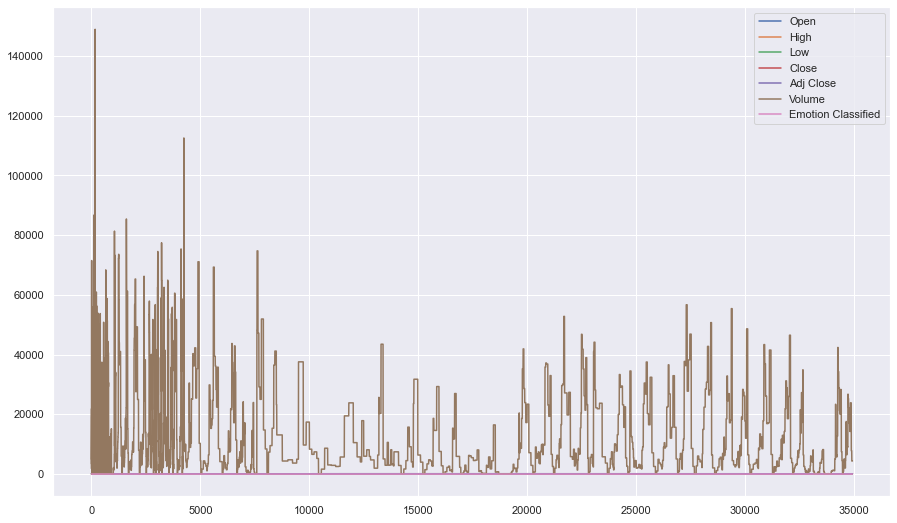

In [203]:
cols = list(df)[1:8]

train_dates = df['date']

df_for_training = df[cols].astype(float)

df_for_plot = df_for_training.tail(len(df_for_training)-1)

df_for_plot.plot.line()

In [204]:
# LSTM uses sigmoud and tanh that are sensitive to 
# normalise the dataset 
scaler = StandardScaler() 
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training) 

In [215]:
trainX = []
trainY = []

n_future = 1 #Number of days we want to predict into the future  
n_past = 14 #Number of days we want to use to predict the future 

for i in range(n_past, len(df_for_training_scaled) - n_future + 1): 
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1: i + n_future, 0]) 

trainX, trainY = np.array(trainX), np.array(trainY)

In [216]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (34930, 14, 7).
trainY shape == (34930, 1).


In [221]:
trainY.shape[0]

34930

In [226]:
# define Autoencoder model 
model = Sequential() 
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse') 
model.summary() 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 14, 64)            18432     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_________________________________________________________________


In [227]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
1965/1965 [==============================] - 20s 10ms/step - loss: 0.0401 - val_loss: 0.0013
Epoch 2/5
1965/1965 [==============================] - 19s 10ms/step - loss: 0.0280 - val_loss: 0.0011
Epoch 3/5
1965/1965 [==============================] - 19s 10ms/step - loss: 0.0267 - val_loss: 8.2340e-04
Epoch 4/5
1965/1965 [==============================] - 19s 10ms/step - loss: 0.0267 - val_loss: 8.6285e-04
Epoch 5/5
1965/1965 [==============================] - 19s 10ms/step - loss: 0.0252 - val_loss: 0.0022


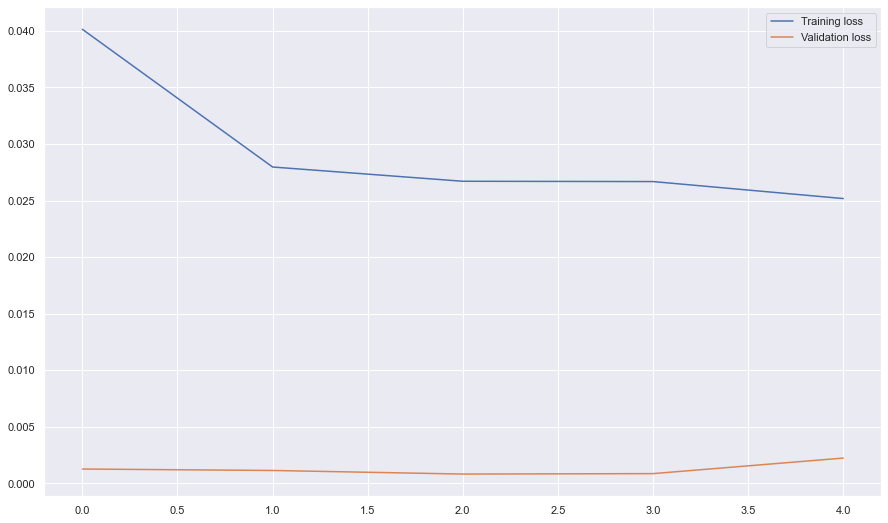

In [228]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [229]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 6 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=5  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2022-04-22 16:00:00+0000', tz='UTC', freq='C'), Timestamp('2022-04-25 16:00:00+0000', tz='UTC', freq='C'), Timestamp('2022-04-26 16:00:00+0000', tz='UTC', freq='C'), Timestamp('2022-04-27 16:00:00+0000', tz='UTC', freq='C'), Timestamp('2022-04-28 16:00:00+0000', tz='UTC', freq='C')]


In [230]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

1/1 [==============================] - 0s 237ms/step


In [231]:
y_pred_future # check against real values

array([101.45926, 101.45375, 101.43766, 101.43926, 101.43757],
      dtype=float32)